<a href="https://colab.research.google.com/github/wasimnawaz1/Pulmo_Disease_Classification/blob/main/pulmo_disease_using_cnn_and_lstm_models_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reset
#import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import scipy.io as sio
import os
from glob import glob

# Disease to label mapping
class_labels = {
    'Asthma_class': 0,
    'COPD_class': 1,
    'ILD_class': 2,
    'Normal_class': 3,
    'PN_class': 4,
    'TB_class': 5
}

# Base directory for all class folders
base_dir = '/content/drive/MyDrive/PULMO_DATA/2025_new_pulmo_data/Class_wise_data'

# Function to downsample columns of a dataframe
def downsample_dataframe(df, factor):
    # Reshape to (64, length/factor, factor), then average along axis 2
    arr = df.values.reshape(df.shape[0], -1, factor)  # (64, length/factor, factor)
    downsampled_arr = arr.mean(axis=2)  # Mean across each 100-column block
    return pd.DataFrame(downsampled_arr)

# Function to load and convert a .mat file to image
def mat_to_image(file_path):
    mat_data = sio.loadmat(file_path)
    data_key = list(mat_data.keys())[-1]
    if data_key not in mat_data:
        print(f"Error: Key '{data_key}' not found in file: {file_path}")
        return None
    data = mat_data[data_key]  # Should be (64, 147000)

    # Subsample columns (every 100th) to get shape (64, 147)
    image = data[:, ::100]
    #image = downsample_dataframe(data, factor = 100)

    return image

# Lists to hold data
images = []
labels = []
subject_ids = []

# Process each file
for class_folder, label in class_labels.items():
    folder_path = os.path.join(base_dir, class_folder)
    mat_files = glob(os.path.join(folder_path, '*.mat'))

    for file_path in mat_files:
        image = mat_to_image(file_path)
        if image is not None:
            images.append(image)  # shape: (64, 147)
            labels.append(label)
            subject_ids.append(os.path.basename(file_path).split('.')[0])

# Convert to arrays
image_data = np.array(images)          # shape: (121, 64, 147)
labels = np.array(labels)          # shape: (121,)
subject_ids = np.array(subject_ids)

# Summary
print("Image tensor shape:", image_data.shape)
print("Labels shape:", labels.shape)
print("Sample Subject_IDs:", subject_ids[:5])
print(f"Memory size: {image_data.nbytes / (1024**2):.2f} MB")

Image tensor shape: (121, 64, 1470)
Labels shape: (121,)
Sample Subject_IDs: ['Asthma_2025_15' 'Asthma_2025_17' 'Asthma_2025_18' 'Asthma_2025_19'
 'Asthma_2025_20']


In [ ]:
#print(labels_np,       subject_ids_np)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
subject_ids = le.fit_transform(subject_ids)
print(subject_ids, '\n',
      len(subject_ids))

In [ ]:
### Saving NumPy image dataset
import numpy as np

# Save to a single .npz file
np.savez('/content/drive/MyDrive/PULMO_DATA/pulmo_dataset_2025.npz',
         image_data=image_data,
         labels=labels,
         subject_ids=subject_ids)

print("Saved to Google Drive at: /content/drive/MyDrive/PULMO_DATA/pulmo_dataset_2025.npz")

Memory size: 86.85 MB
Saved to Google Drive at: /content/drive/MyDrive/PULMO_DATA/pulmo_dataset_2025.npz


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5
 5 5 5 5 5 5 5 5 5 5] 
 [  6   8   9  10  12   2  18   5   4   3  11  13  15   1  16   0  17  19
  14   7  20  37  38  39  40  41  21  22  23  24  25  26  27  28  29  30
  32  33  34  35  36  31  43  42  60  61  48  50  53  54  57  59  46  66
  65  62  55  51  64  49  52  58  44  63  56  45  47  67  78  83  85  86
  71  79  72  89  70  84  77  88  73  87  81  80  76  69  74  68  75  82
  90  99 100 101 103 104 105  93  94  96  97 102 106  92  91  98  95 107
 109 111 112 115 117 119 120 108 118 116 114 113 110] 
 121 
 (121, 64, 1470)


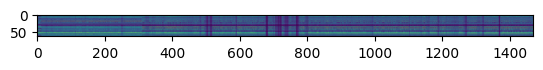

In [ ]:
### Loading saved NumPy image dataset
import numpy as np
import matplotlib.pyplot as plt
data = np.load('/content/drive/MyDrive/PULMO_DATA/pulmo_dataset_2025.npz')
image_data = data['image_data']
labels = data['labels']
subject_ids = data['subject_ids']

print(labels, '\n',
      subject_ids, '\n',
      len(image_data), '\n',
      image_data.shape)

plt.imshow(image_data[100])


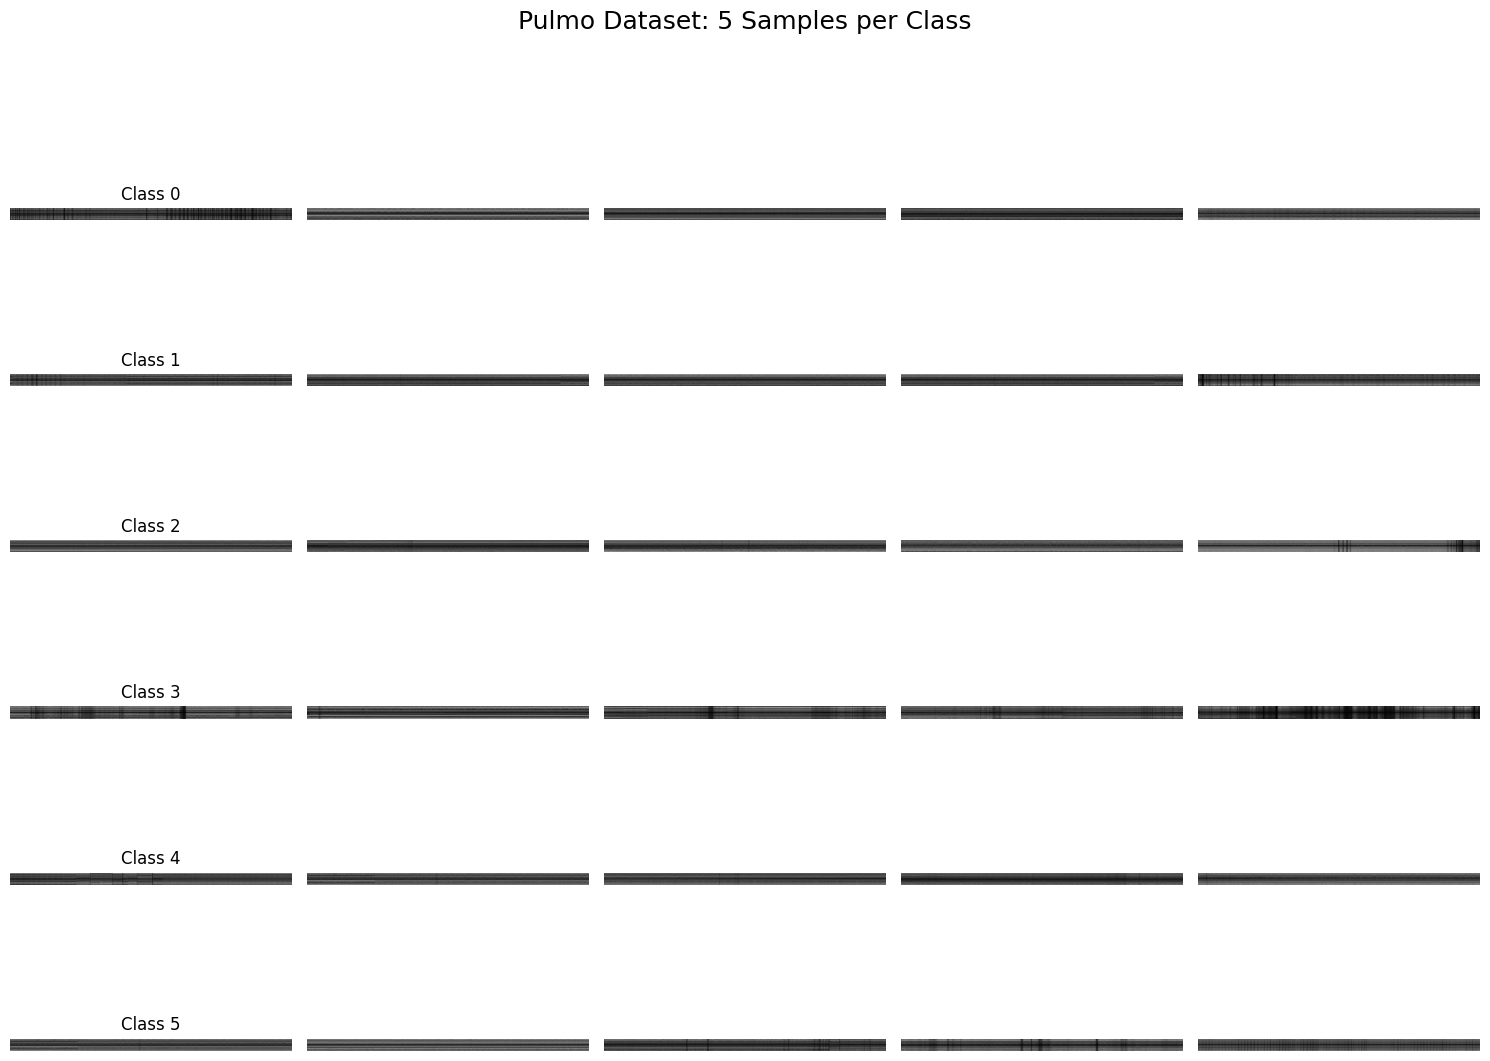

Image saved at: /content/pulmo_5_samples_per_class.png


In [ ]:
# Parameters
num_classes = 6
samples_per_class = 5

# Create figure
fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(15, 12))
fig.suptitle('Pulmo Dataset: 5 Samples per Class', fontsize=18)

# Plot images
for class_label in range(num_classes):
    class_indices = np.where(labels == class_label)[0][:samples_per_class]
    for i, idx in enumerate(class_indices):
        ax = axes[class_label, i]
        ax.imshow(image_data[idx], cmap='gray')
        ax.axis('off')
        ax.set_title(f'Class {class_label}' if i == 0 else '')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
output_path = '/content/pulmo_5_samples_per_class.png'
plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1, dpi=1200)
plt.show()

print(f"Image saved at: {output_path}")



In [ ]:
from collections import Counter

# Number of images per label
label_counts = Counter(labels)
print("Label distribution:", label_counts)

# Just to make sure subject_ids match labels
for i in range(4):
    print(f"{subject_ids[i]} -> Label: {labels[i]}")


Label distribution: Counter({np.int64(1): 24, np.int64(2): 23, np.int64(3): 23, np.int64(0): 20, np.int64(4): 17, np.int64(5): 14})
6 -> Label: 0
8 -> Label: 0
9 -> Label: 0
10 -> Label: 0


Extracted patches shape: (1210, 64, 256)
Labels shape: (1210,)
Subject IDs shape: (1210,)
Unique subject IDs: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120]
Number of unique subject IDs: 121


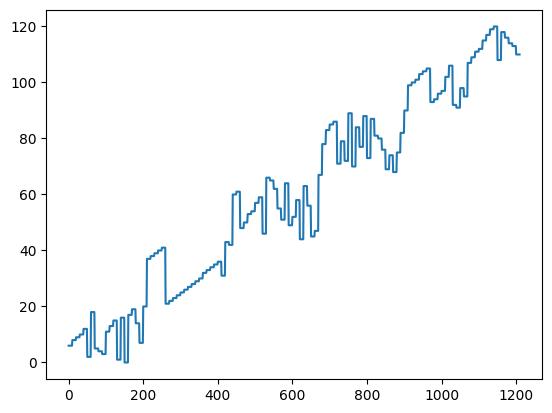

In [ ]:
import numpy as np
from sklearn.feature_extraction.image import extract_patches_2d

# Assuming:
# image_data.shape = (121, 64, 1470)
# labels.shape = (121,)
# subject_ids.shape = (121,) – one ID per image

patch_size = (64, 256)
step_size = 128  # Overlapping patches if step < patch_size

patches = []
patch_labels = []
patch_subject_ids = []

for i in range(image_data.shape[0]):  # For each image
    image = image_data[i]
    label = labels[i]
    subject_id = subject_ids[i]  # Keep track of subject

    # Check if patching is possible
    if image.shape[0] >= patch_size[0] and image.shape[1] >= patch_size[1]:
        for row in range(0, image.shape[0] - patch_size[0] + 1, step_size):
            for col in range(0, image.shape[1] - patch_size[1] + 1, step_size):
                patch = image[row:row+patch_size[0], col:col+patch_size[1]]
                patches.append(patch)
                patch_labels.append(label)
                patch_subject_ids.append(subject_id)  # Add subject ID

# Convert to arrays
patches = np.array(patches)            # Shape: (N_patches, 64, 64)
patch_labels = np.array(patch_labels)  # Shape: (N_patches,)
patch_subject_ids = np.array(patch_subject_ids)  # Shape: (N_patches,)

print("Extracted patches shape:", patches.shape)
print("Labels shape:", patch_labels.shape)
print("Subject IDs shape:", patch_subject_ids.shape)


plt.plot(patch_subject_ids)

unique_subject_ids = np.unique(patch_subject_ids)
print("Unique subject IDs:", unique_subject_ids)
print("Number of unique subject IDs:", len(unique_subject_ids))

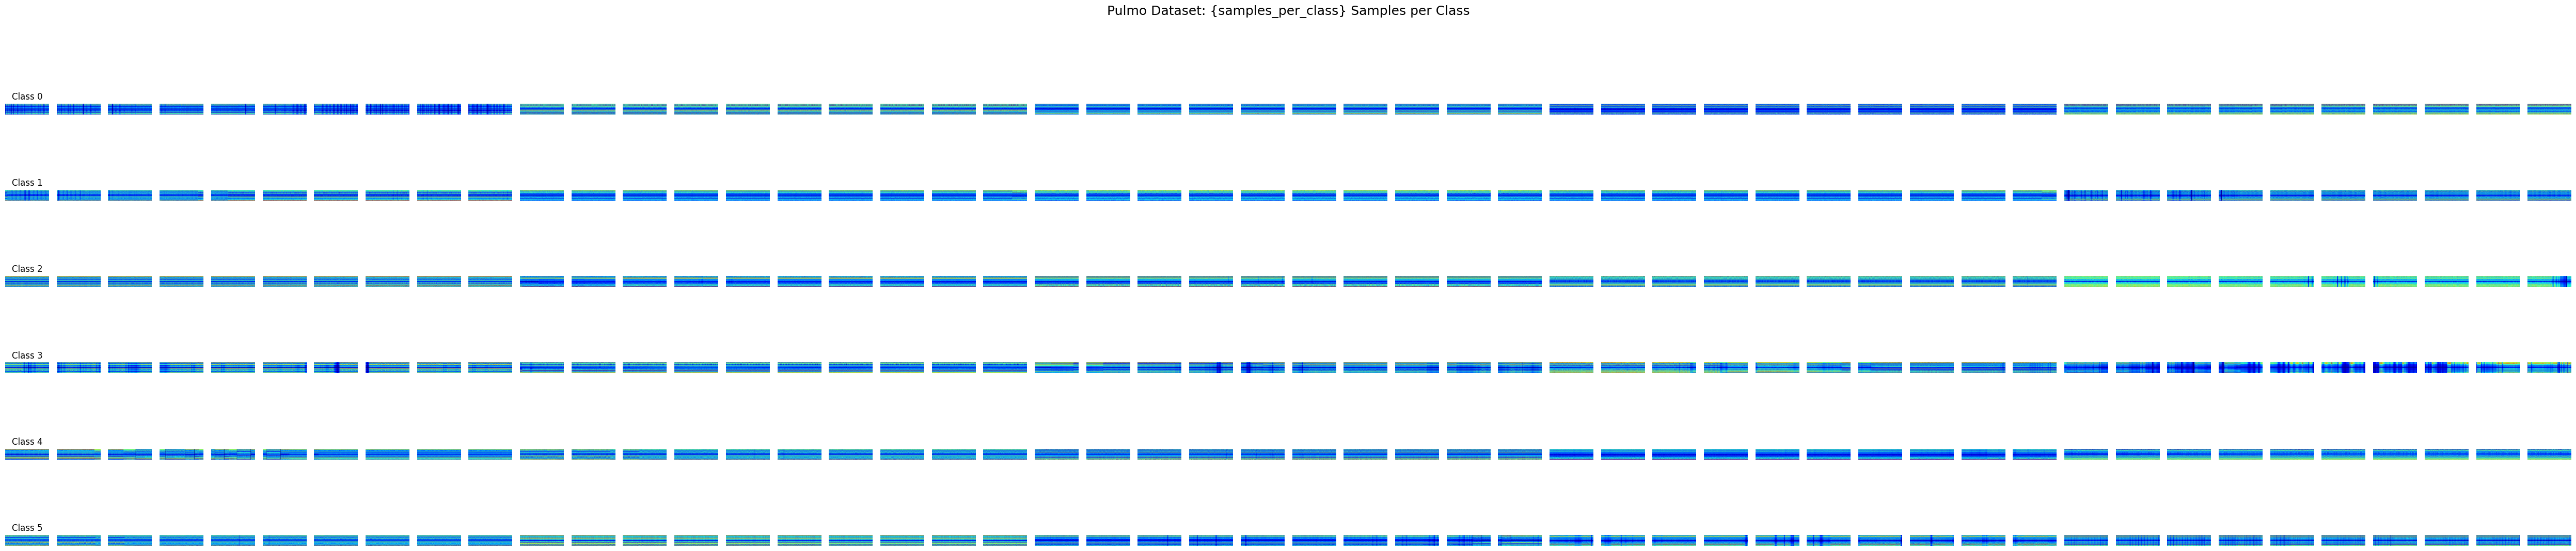

Image saved at: /content/pulmo_{samples_per_class}_samples_per_class.png


In [ ]:
# Parameters
num_classes = 6
samples_per_class = 50

# Create figure
fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(50, 12))
fig.suptitle(r'Pulmo Dataset: {samples_per_class} Samples per Class', fontsize=18)

all_colormaps = plt.colormaps()

# Plot images
for class_label in range(num_classes):
    class_indices = np.where(patch_labels == class_label)[0][:samples_per_class]
    for i, idx in enumerate(class_indices):
        ax = axes[class_label, i]
        #ax.imshow(patches[idx], cmap=all_colormaps[6])
        ax.imshow(patches[idx], cmap='jet')
        ax.axis('off')
        ax.set_title(f'Class {class_label}' if i == 0 else '')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
output_path = r'/content/pulmo_{samples_per_class}_samples_per_class.png'
plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1, dpi=1200)
plt.show()

print(f"Image saved at: {output_path}")



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU, BatchNormalization

from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, MobileNetV2, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

model_used = 'CNN'
model_used = 'transferred'
# Convert the image data to numpy arrays
#image_data = image_data.tolist()
#labels = labels.values

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.3, random_state=20)

# Get unique subjects
unique_subjects = np.unique(patch_subject_ids)

# Split subjects
train_subj, test_subj = train_test_split(unique_subjects, test_size=0.2, random_state=42)

# Mask for patches
train_mask = np.isin(patch_subject_ids, train_subj)
test_mask = np.isin(patch_subject_ids, test_subj)

# Split patches
X_train = patches[train_mask]
y_train = patch_labels[train_mask]
X_test = patches[test_mask]
y_test = patch_labels[test_mask]


X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.3, random_state=20)

if(model_used == 'CNN'):
    # Add channel axis (assuming Gray/RGB images   ---  1/3 )
    X_train = np.repeat(X_train[..., np.newaxis], 1, axis=-1)
    X_test = np.repeat(X_test[..., np.newaxis], 1, axis=-1)
elif(model_used == 'transferred'):
    X_train = np.repeat(X_train[..., np.newaxis], 3, axis=-1)
    X_test = np.repeat(X_test[..., np.newaxis], 3, axis=-1)

# Resize all images to 224x224
#X_train = np.array([img_to_array(array_to_img(img).resize((224, 224))) for img in X_train])
#X_test = np.array([img_to_array(array_to_img(img).resize((224, 224))) for img in X_test])

# Normalize the data using Min-Max Scaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = np.zeros_like(X_train)
X_test_scaled = np.zeros_like(X_test)

for i in range(X_train.shape[0]):
    X_train_scaled[i] = scaler.fit_transform(X_train[i].reshape(-1, X_train.shape[-1])).reshape(X_train[i].shape)

for i in range(X_test.shape[0]):
    X_test_scaled[i] = scaler.fit_transform(X_test[i].reshape(-1, X_test.shape[-1])).reshape(X_test[i].shape)

# One-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=128,
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow(
    X_test, y_test,
    batch_size=128,
    subset='validation',
    shuffle=False
)


# CNN Model
def CNN_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(X_train.shape[1], X_train.shape[2], 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(16, (3, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
   # model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.4))
    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.4))
    model.add(Dense(16))
    model.add(Dropout(0.4))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    return model


def tranferred_model():
    # Load the pre-trained VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], 3))
    #base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2], 3))
    #base_model = ResNet50(  weights='imagenet', include_top=False,    input_shape=(X_train.shape[1], X_train.shape[2], 3))

    # Freeze the base model's layers
    base_model.trainable = False

    # Unfreeze the last few layers
    for layer in base_model.layers[-5:]:
        layer.trainable = True

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)

    x_out = Dense(y_train.shape[1], activation='softmax')(x)
    # Create the new model
    model = Model(inputs=base_model.input, outputs=x_out)
    return model

if(model_used == 'CNN'):
    model = CNN_model()
elif(model_used == 'transferred'):
    model = tranferred_model()


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary(expand_nested=True)


callbacks = [    EarlyStopping(patience=5, restore_best_weights=True),    ReduceLROnPlateau(factor=0.3, patience=5) ]


# Training and Evaluation

model.fit(X_train_scaled, y_train, epochs=50, batch_size=128, validation_data=(X_test_scaled, y_test))
#model.fit(train_generator, epochs=20, batch_size=128, validation_data=val_generator,)
          #callbacks=callbacks)


y_pred = model.predict(X_test_scaled)
y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_class, y_pred_class)
print(f'Test accuracy: {accuracy:.3f}')

NameError: name 'patch_subject_ids' is not defined

In [ ]:
type(y_train)

numpy.ndarray

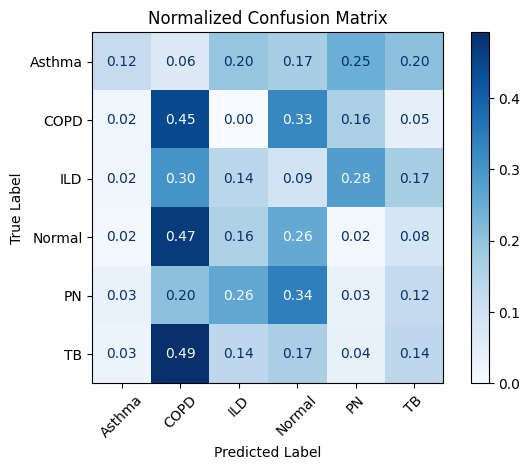

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Compute normalized confusion matrix
cm_normalized = confusion_matrix(y_test_class, y_pred_class, normalize='true')

# 2. Class names (customize if needed)
class_names = ['Asthma', 'COPD', 'ILD', 'Normal', 'PN', 'TB']

# 3. Display heatmap with normalized values
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")

plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

dataset_path = r'/content/drive/MyDrive/PULMO_DATA/xlsx'
TB_dataset_path = r'/content/drive/MyDrive/PULMO_DATA/xlsx/TB'
PN_dataset_path = r'/content/drive/MyDrive/PULMO_DATA/xlsx/PN'
ILD_dataset_path = r'/content/drive/MyDrive/PULMO_DATA/xlsx/ILD'
COPD_dataset_path = r'/content/drive/MyDrive/PULMO_DATA/xlsx/COPD'
Asthma_dataset_path = r'/content/drive/MyDrive/PULMO_DATA/xlsx/Asthma'
Normal_dataset_path = r'/content/drive/MyDrive/PULMO_DATA/xlsx/Normal'


new_dataset_path = r'/content/drive/MyDrive/PULMO_DATA/2025_new_pulmo_data/Excel__file_pulmo_2025'
new_TB_dataset_path = r'/content/drive/MyDrive/PULMO_DATA/2025_new_pulmo_data/Excel__file_pulmo_2025/TB'
new_PN_dataset_path = r'/content/drive/MyDrive/PULMO_DATA/2025_new_pulmo_data/Excel__file_pulmo_2025/PN'
new_ILD_dataset_path = r'/content/drive/MyDrive/PULMO_DATA/2025_new_pulmo_data/Excel__file_pulmo_2025/ILD'
new_COPD_dataset_path = r'/content/drive/MyDrive/PULMO_DATA/2025_new_pulmo_data/Excel__file_pulmo_2025/COPD'
new_Asthma_dataset_path = r'/content/drive/MyDrive/PULMO_DATA/2025_new_pulmo_data/Excel__file_pulmo_2025/Asthma'
new_Normal_dataset_path = r'/content/drive/MyDrive/PULMO_DATA/2025_new_pulmo_data/Excel__file_pulmo_2025/Normal'

In [ ]:
### 2025 newly collected dataset paths
#r'/content/drive/MyDrive/PULMO_DATA/2025_new_pulmo_data/Class_wise_data/Asthma_class'
#r'/content/drive/MyDrive/PULMO_DATA/2025_new_pulmo_data/Class_wise_data/COPD_class'
#r'/content/drive/MyDrive/PULMO_DATA/2025_new_pulmo_data/Class_wise_data/ILD_class'
#r'/content/drive/MyDrive/PULMO_DATA/2025_new_pulmo_data/Class_wise_data/Normal_class'
#r'/content/drive/MyDrive/PULMO_DATA/2025_new_pulmo_data/Class_wise_data/PN_class'
#r'/content/drive/MyDrive/PULMO_DATA/2025_new_pulmo_data/Class_wise_data/TB_class'
#r'/content/drive/MyDrive/PULMO_DATA/2025_new_pulmo_data/Class_wise_data/Asthma_class'

In [ ]:
import numpy as np
import pandas as pd
import scipy.io as sio
import os
from glob import glob

# Disease to label mapping
class_labels = {
    'Asthma_class': 0,
    'COPD_class': 1,
    'ILD_class': 2,
    'Normal_class': 3,
    'PN_class': 4,
    'TB_class': 5
}

# Base directory for all class folders
base_dir = '/content/drive/MyDrive/PULMO_DATA/2025_new_pulmo_data/Class_wise_data'

# Function to load a .mat file into DataFrame
def load_mat_to_dataframe(file_path):
    mat_data = sio.loadmat(file_path)
    data_key = list(mat_data.keys())[-1]  # Usually the last key is the actual data
    if data_key not in mat_data:
        print(f"Error: Key '{data_key}' not found in file: {file_path}")
        return None
    data = mat_data[data_key]
    df = pd.DataFrame(data)
    return df

# Load all files from each disease class folder
all_dataframes = []
for class_folder, label in class_labels.items():
    folder_path = os.path.join(base_dir, class_folder)
    mat_files = glob(os.path.join(folder_path, '*.mat'))

    for file_path in mat_files:
        df = load_mat_to_dataframe(file_path)
        if df is not None:
            df = df.iloc[:, ::100]  # Subsample features (every 100th column)
            df = df.T               # transposing the dataframe so that we have 64 frequencies as columns
            df['Disease'] = label   # Assign disease label
            df['Subject_ID'] = os.path.basename(file_path).split('.')[0]  # Use filename (without .mat) as ID
            all_dataframes.append(df)

# Combine all subject-level DataFrames
final_df = pd.concat(all_dataframes, ignore_index=True)

# Summary
print("Combined DataFrame shape:", final_df.shape)
print("Label distribution:\n", final_df['Disease'].value_counts())
print("Sample Subject_IDs:", final_df['Subject_ID'].unique()[:5])


Combined DataFrame shape: (7744, 737)
Label distribution:
 Disease
1    1536
2    1472
3    1472
0    1280
4    1088
5     896
Name: count, dtype: int64
Sample Subject_IDs: ['Asthma_2025_15' 'Asthma_2025_17' 'Asthma_2025_18' 'Asthma_2025_19'
 'Asthma_2025_20']


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
final_df['Subject_ID'] = le.fit_transform(final_df['Subject_ID'])
#final_df['Subject_ID'] = final_df['Subject_ID_Int']
#final_df.drop(columns=['Subject_ID'], inplace=True)
print(final_df['Subject_ID'].value_counts())
final_df

Subject_ID
6      64
8      64
9      64
10     64
12     64
       ..
118    64
116    64
114    64
113    64
110    64
Name: count, Length: 121, dtype: int64


,0,200,400,600,800,1000,1200,1400,1600,1800,...,145400,145600,145800,146000,146200,146400,146600,146800,Disease,Subject_ID
0,20.334640,29.639143,55.207569,73.712878,64.716956,60.301351,52.134264,29.865325,13.159471,52.543401,...,54.888671,65.067154,53.962824,25.347095,22.318622,26.107040,30.653714,32.042071,0,6
1,62.527749,96.167052,126.881540,137.932071,133.672186,142.000578,121.607314,95.559914,39.754139,129.617034,...,121.442603,115.995190,112.971636,93.120137,79.707759,91.233192,87.907924,100.029222,0,6
2,25.101552,37.110089,70.699248,20.670856,32.228510,78.079800,29.263649,36.039151,16.298423,68.030303,...,40.585640,47.615291,36.466539,44.121661,36.608693,43.961075,42.134828,58.198968,0,6
3,65.039381,95.814412,123.827238,155.938036,141.054015,147.133735,129.902113,94.504644,41.024295,135.090076,...,143.634964,139.940987,140.577226,96.460995,76.689495,101.388224,92.794362,104.594577,0,6
4,64.602112,90.900029,96.968103,107.935049,94.823978,106.969303,103.892145,91.540016,41.359239,102.863343,...,98.093880,102.242726,100.175947,94.887662,83.608536,96.759795,97.198997,95.413436,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7739,60.532661,80.422825,56.976108,58.866424,54.218896,53.030946,62.574257,58.593475,58.882046,68.803131,...,150.053033,159.522228,148.333199,159.509691,150.165699,149.187595,153.821321,86.429457,5,110
7740,178.807062,156.393713,157.881358,170.655328,176.138013,173.877894,152.604994,171.783974,180.337413,169.056988,...,78.459268,62.826424,51.032514,75.402841,69.191585,69.951024,70.533958,148.559780,5,110
7741,52.259106,83.592236,64.200055,52.081102,42.577867,63.171320,104.824092,91.278058,47.038346,64.850205,...,89.152823,28.169732,28.754920,75.584723,19.011429,41.486382,53.523635,114.326487,5,110
7742,96.562237,108.413154,56.525732,107.802579,86.578017,76.275132,90.457766,81.907404,96.633383,112.361990,...,194.660842,202.167182,211.855750,187.179008,212.165915,211.119734,202.117668,64.129618,5,110


In [ ]:
pulmo = '/content/drive/MyDrive/PULMO_DATA/xlsx/pulmo_combined_subsampled_20_percent_rows_n_columns_normal_class_name_added.csv'

final_df = pd.read_csv(pulmo)
final_df['Disease'].value_counts()

#new_pulmo = '/content/drive/MyDrive/PULMO_DATA/xlsx/new_pulmo_combined_subsampled_50_percent_rows_n_columns_normal_class_name_added.csv'

#new_df = pd.read_csv(new_pulmo)
#new_df['Disease'].value_counts()

,count
Disease,
1,53900
4,49000
0,49000
5,24500
3,24500
2,14700


In [ ]:
#TB_dataset_path
#dirname
#filenames
#excel_file
#os.walk(TB_dataset_path)
#print(os.path.join(dirname, filename))
#i=1
#for filename in filenames:
    #print(i)
    #i = i+1

In [ ]:
import os

def get_excel_files(*dataset_paths):
    """
    Takes multiple dataset paths and returns a list of lists containing Excel file paths.

    Parameters:
    dataset_paths (str): Variable-length arguments of directory paths.

    Returns:
    list: A list where each element is a list of Excel file paths for a given dataset.
    """
    excel_files = []

    for dataset_path in dataset_paths:
        dataset_excel_files = []
        for dirname, _, filenames in os.walk(dataset_path):
            for filename in filenames:
                excel_file = os.path.join(dirname, filename)
                print(excel_file)  # Optional: Print file paths for verification
                dataset_excel_files.append(excel_file)
        excel_files.append(dataset_excel_files)

    return excel_files

# Example usage:
excel_files = get_excel_files(Normal_dataset_path, TB_dataset_path, PN_dataset_path, ILD_dataset_path,
                              COPD_dataset_path, Asthma_dataset_path)
new_excel_files = get_excel_files(new_Normal_dataset_path, new_TB_dataset_path, new_PN_dataset_path,
                                  new_ILD_dataset_path, new_COPD_dataset_path, new_Asthma_dataset_path)


In [ ]:
excel_files[0][0]

'/content/drive/MyDrive/PULMO_DATA/xlsx/Normal/Normal_1_segment_1.xlsx'

In [ ]:
import os
import pandas as pd
import re

def extract_subject_id(filename):
    """
    Extracts the subject number from the filename.

    Examples:
    - "A_6_segment_14.xlsx" -> 6
    - "ILD_2_segment_1.xlsx" -> 2
    - "Normal_1_segment_10.xlsx" -> 1
    - "TB_3_segment_3.xlsx" -> 3

    Parameters:
    filename (str): The name of the file.

    Returns:
    int: The extracted subject ID or None if not found.
    """
    match = re.search(r'_(\d+)_segment', filename)
    return int(match.group(1)) if match else None

print(excel_files[5][35], '\n',
      extract_subject_id(excel_files[5][35]))


/content/drive/MyDrive/PULMO_DATA/xlsx/Asthma/A_3_segment_12.xlsx 
 3


In [ ]:
len(excel_files[4])
#excel_files
#len(selected_excel_files[5])


203

In [ ]:
# List of classes and their corresponding labels
class_labels = {
    'Asthma': 0,
    'COPD': 1,
    'ILD': 2,
    'Normal': 3,
    'PN': 4,
    'TB': 5,

}

class_labels.keys()
# Get the class name from the appropriate position. Assuming that the class name is the second last part of the path
#parts = file.split('\\')
#class_name = parts[-2]
#print(class_name, '\n', class_labels[class_name])


dict_keys(['Asthma', 'COPD', 'ILD', 'Normal', 'PN', 'TB'])

In [ ]:
import pandas as pd
from tqdm import tqdm
import os

# Select a subset of the excel_files from each disease
step = 20   # select every 10th file
selected_excel_files = [selected_files[1::step] for selected_files in excel_files]
new_selected_excel_files = [new_selected_files[1::step] for new_selected_files in new_excel_files]

print(len(selected_excel_files[4]))
#selected_excel_files
#a= [['a', 'b', 'c', 'd'], ['e', 'f', 'g', 'h']]
#result = [sublist[1::2] for sublist in a]
#print(result)


def process_excel_files(selected_excel_files, class_labels, row_sample_frac, col_sample_frac):
    """
    Reads, processes, and samples Excel files, then appends them into a list of DataFrames.

    Parameters:
    - selected_excel_files (list of lists): A list containing lists of file paths categorized by disease.
    - class_labels (dict): A dictionary mapping folder names to class labels.
    - row_sample_frac (float): Fraction of rows to sample (default: 0.49).
    - col_sample_frac (float): Fraction of columns to sample (default: 0.49).

    Returns:
    - list: A list of processed DataFrames.
    """
    dfs = []

    # Iterate over each list of Excel files (each corresponding to a disease category)
    for excel_files in selected_excel_files:
        for file in tqdm(excel_files, desc="Reading Excel Files", unit="file"):

            # Read Excel file
            temp = pd.read_excel(file, header=None)

            # Transpose (rows become columns)
            temp_transposed = temp.T

            # Randomly sample rows and columns
            temp_transposed = temp_transposed.sample(frac=row_sample_frac, replace=False)
            temp_transposed = temp_transposed.sample(frac=col_sample_frac, axis='columns', replace=False)

            # Remove row and column names
            temp_transposed.index = [None] * len(temp_transposed.index)
            temp_transposed.columns = [None] * len(temp_transposed.columns)

            # Add a new column for the class label
            #class_name = os.path.basename(os.path.dirname(file))  # Get folder name (disease type)
            #temp_transposed['Disease'] = class_labels.get(class_name, "Unknown")

             # Add a new column for the class label
            class_name = file.split('/')[-2]       # picking up the folder name, where .xlsx files of a particular disease are
            temp_transposed['Disease'] = class_labels[class_name]

            # Append processed DataFrame
            dfs.append(temp_transposed)

    return dfs

# Example usage:
class_labels = {    'Asthma': 0,    'COPD': 1,    'ILD': 2,    'PN': 3,    'TB': 4,    'Normal': 5}
processed_dfs = process_excel_files(selected_excel_files, class_labels, row_sample_frac=0.99, col_sample_frac=0.99)
new_processed_dfs = process_excel_files(new_selected_excel_files, class_labels, row_sample_frac=0.99, col_sample_frac=0.99)


11


Reading Excel Files: 100%|██████████| 14/14 [03:22<00:00, 14.44s/file]


In [ ]:
#file.split('/')#[-2]
#file.split('//')

['', 'content', 'drive', 'MyDrive', 'PULMO_DATA', 'xlsx', 'PN', 'Pn_9.jpg']

In [ ]:
# Concatenate all DataFrames into a single DataFrame if needed
final_df = pd.concat(processed_dfs, ignore_index=True)
#print(final_df)
new_final_df = pd.concat(new_processed_dfs, ignore_index=True)
#print(new_final_df)
new_final_df
final_df

,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,Disease
0,7.793869,15.698911,6.436312,10.713863,28.471165,18.637017,25.389914,6.394905,30.777957,24.337489,...,11.817772,16.849710,13.464637,25.952176,5.157167,19.680871,12.504793,4.930655,15.095939,5
1,8.497224,17.287799,9.804110,10.668582,28.092017,17.851163,25.112626,5.976623,30.774037,24.057907,...,12.579957,18.494376,13.192448,26.032380,5.635830,19.674128,11.604554,5.818836,14.188016,5
2,5.723080,11.178714,6.124993,6.987693,18.802811,12.113419,16.528824,3.862990,20.866850,16.454845,...,8.418200,12.128249,8.712752,17.520355,3.652165,13.399066,7.603776,3.826626,9.772509,5
3,7.336699,15.721343,6.154961,10.937317,28.689174,19.104823,25.455675,6.668027,30.534175,24.257219,...,11.984537,16.451259,13.360383,25.857615,5.277927,20.251581,12.707742,5.049085,15.168544,5
4,4.065193,8.833300,3.653329,6.312304,16.250830,10.837181,14.476303,3.771685,17.519088,13.547257,...,6.498040,8.959056,7.996441,14.318167,3.286709,11.319601,7.491888,2.512576,8.797147,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215595,219.869995,84.317889,17.236199,35.657270,69.935152,45.711779,87.890324,97.391859,49.843272,64.511919,...,128.221732,64.366097,76.720700,91.867204,54.273396,99.569366,41.762098,103.833995,32.754448,0
215596,258.194044,70.290623,18.535868,37.321007,97.062165,57.106096,103.904353,121.721884,34.635801,75.482316,...,127.504706,45.257184,53.185611,82.538464,44.477691,108.412300,25.230330,100.554082,40.922170,0
215597,245.036102,77.136788,9.295632,42.996103,107.521585,89.669622,106.260802,99.905052,42.299982,65.906930,...,134.041804,60.142338,57.515787,66.054420,15.230833,112.942585,24.913951,35.876230,50.998252,0
215598,255.362531,64.628897,15.906964,40.692520,100.046054,56.689499,111.905932,116.163263,37.141167,81.224681,...,124.685545,54.357761,51.130849,80.947624,37.040479,106.877756,24.900299,93.575803,47.725957,0


In [ ]:
final_df = df.copy()

In [ ]:
import numpy as np
print("original length of df:", len(final_df))
final_df.replace([np.inf, -np.inf], np.nan, inplace=True)
final_df.dropna(inplace=True)
print("after dropping null values, the length of df:", len(final_df))


print("original length of df:", len(new_final_df))
new_final_df.replace([np.inf, -np.inf], np.nan, inplace=True)
new_final_df.dropna(inplace=True)
print("after dropping null values, the length of df:", len(new_final_df))

original length of df: 3840
after dropping null values, the length of df: 3840


NameError: name 'new_final_df' is not defined

In [ ]:
final_df.columns = ['feature'+str(i) for i in range(len(final_df.columns[:-1]))] + ['Disease']
new_final_df.columns = ['feature'+str(i) for i in range(len(new_final_df.columns[:-1]))] + ['Disease']

final_df
new_final_df

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,Disease
0,39.521391,29.058883,19.775402,64.970553,79.449394,36.992985,34.003482,37.997723,58.889915,121.107883,...,115.954124,105.795899,77.216318,48.566172,48.550678,19.534763,8.974934,89.126614,84.260358,5
1,39.431547,10.712242,11.512433,43.987592,72.246460,29.916835,37.551504,30.019702,40.634092,81.369103,...,70.380392,64.813292,48.344471,36.910622,42.591740,10.813867,5.560595,55.609442,46.159353,5
2,35.006962,13.015427,11.851272,40.484646,65.266690,29.864734,37.411732,26.236381,37.035325,78.811176,...,68.792680,63.854707,49.010901,28.352624,44.056595,9.001675,6.938624,59.213912,46.682103,5
3,51.783584,21.577430,27.424823,47.483917,87.603749,28.636322,43.109713,48.765016,33.791386,136.282613,...,98.397941,112.072538,71.623776,53.332678,33.582999,15.461322,8.773831,80.784426,85.612702,5
4,27.500780,13.958047,31.489167,76.456594,120.071346,81.037166,58.789296,31.406386,61.703694,109.033376,...,92.915400,84.011282,67.996771,54.940906,71.405241,26.599958,7.143229,55.739446,64.338568,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426295,22.737360,113.476239,55.361289,73.619937,52.082284,121.667833,95.189785,90.969861,42.743210,149.537583,...,57.062446,77.841863,55.612510,152.493031,75.601586,134.115092,57.042761,29.630352,70.623613,0
426296,12.420187,105.388693,53.780259,60.165066,33.573963,135.155490,84.526347,74.992265,42.369000,151.817897,...,39.614997,112.938033,52.830841,154.659561,75.076418,132.510107,52.500540,9.949471,96.259224,0
426297,23.874976,111.478705,51.298270,67.917970,52.749910,102.656655,115.536957,85.092911,49.010709,158.304130,...,48.074166,43.062151,63.229021,169.382404,71.125640,124.886828,54.592423,40.357844,68.607369,0
426298,22.711375,111.722677,54.912106,72.603809,48.017272,125.876455,88.244813,89.825891,48.246798,149.179354,...,54.214581,92.561765,56.724134,152.493967,76.806813,129.660824,56.954552,24.572714,76.199740,0


In [ ]:
# saving the combined csv file
final_df.to_csv(os.path.join(dataset_path, 'pulmo_combined_subsampled_20_percent_rows_n_columns_normal_class_name_added.csv'), index=False)
new_final_df.to_csv(os.path.join(dataset_path, 'pulmo_combined_subsampled_20_percent_rows_n_columns_normal_class_name_added_new.csv'), index=False)
final_df

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,Disease
0,39.521391,29.058883,19.775402,64.970553,79.449394,36.992985,34.003482,37.997723,58.889915,121.107883,...,115.954124,105.795899,77.216318,48.566172,48.550678,19.534763,8.974934,89.126614,84.260358,5
1,39.431547,10.712242,11.512433,43.987592,72.246460,29.916835,37.551504,30.019702,40.634092,81.369103,...,70.380392,64.813292,48.344471,36.910622,42.591740,10.813867,5.560595,55.609442,46.159353,5
2,35.006962,13.015427,11.851272,40.484646,65.266690,29.864734,37.411732,26.236381,37.035325,78.811176,...,68.792680,63.854707,49.010901,28.352624,44.056595,9.001675,6.938624,59.213912,46.682103,5
3,51.783584,21.577430,27.424823,47.483917,87.603749,28.636322,43.109713,48.765016,33.791386,136.282613,...,98.397941,112.072538,71.623776,53.332678,33.582999,15.461322,8.773831,80.784426,85.612702,5
4,27.500780,13.958047,31.489167,76.456594,120.071346,81.037166,58.789296,31.406386,61.703694,109.033376,...,92.915400,84.011282,67.996771,54.940906,71.405241,26.599958,7.143229,55.739446,64.338568,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426295,22.737360,113.476239,55.361289,73.619937,52.082284,121.667833,95.189785,90.969861,42.743210,149.537583,...,57.062446,77.841863,55.612510,152.493031,75.601586,134.115092,57.042761,29.630352,70.623613,0
426296,12.420187,105.388693,53.780259,60.165066,33.573963,135.155490,84.526347,74.992265,42.369000,151.817897,...,39.614997,112.938033,52.830841,154.659561,75.076418,132.510107,52.500540,9.949471,96.259224,0
426297,23.874976,111.478705,51.298270,67.917970,52.749910,102.656655,115.536957,85.092911,49.010709,158.304130,...,48.074166,43.062151,63.229021,169.382404,71.125640,124.886828,54.592423,40.357844,68.607369,0
426298,22.711375,111.722677,54.912106,72.603809,48.017272,125.876455,88.244813,89.825891,48.246798,149.179354,...,54.214581,92.561765,56.724134,152.493967,76.806813,129.660824,56.954552,24.572714,76.199740,0


In [ ]:
final_df['Disease'].value_counts()

,count
Disease,
1,1536
2,1472
3,1472
0,1280
4,1088
5,896


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

final_df = pd.read_csv('/content/drive/MyDrive/PULMO_DATA/xlsx/pulmo_combined_subsampled_20_percent_rows_n_columns_normal_class_name_added.csv')     # 20% samples
#final_df = pd.read_csv('/content/drive/MyDrive/PULMO_DATA/xlsx/pulmo_combined_subsampled_1_percent_rows_n_columns_normal_class_name_added.csv')
#new_final_df = pd.read_csv('/content/drive/MyDrive/PULMO_DATA/xlsx/pulmo_combined_subsampled_20_percent_rows_n_columns_normal_class_name_added_new.csv')     # 20% samples

final_df.drop(columns='Subject_ID', inplace=True)
final_df


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/PULMO_DATA/xlsx/pulmo_combined_subsampled_20_percent_rows_n_columns_normal_class_name_added.csv'

In [ ]:
print(final_df.isna().sum(), '\n',
      final_df.isnull().sum(), '\n',
      final_df.columns, '\n',
      final_df.Disease.value_counts(), '\n',
      new_final_df.isna().sum(), '\n',
      new_final_df.isnull().sum(), '\n',
      new_final_df.columns, '\n',
      new_final_df.Disease.value_counts())

NameError: name 'new_final_df' is not defined

In [ ]:
final_df

,0,200,400,600,800,1000,1200,1400,1600,1800,...,145400,145600,145800,146000,146200,146400,146600,146800,Disease,Subject_ID
0,20.334640,29.639143,55.207569,73.712878,64.716956,60.301351,52.134264,29.865325,13.159471,52.543401,...,54.888671,65.067154,53.962824,25.347095,22.318622,26.107040,30.653714,32.042071,0,6
1,62.527749,96.167052,126.881540,137.932071,133.672186,142.000578,121.607314,95.559914,39.754139,129.617034,...,121.442603,115.995190,112.971636,93.120137,79.707759,91.233192,87.907924,100.029222,0,6
2,25.101552,37.110089,70.699248,20.670856,32.228510,78.079800,29.263649,36.039151,16.298423,68.030303,...,40.585640,47.615291,36.466539,44.121661,36.608693,43.961075,42.134828,58.198968,0,6
3,65.039381,95.814412,123.827238,155.938036,141.054015,147.133735,129.902113,94.504644,41.024295,135.090076,...,143.634964,139.940987,140.577226,96.460995,76.689495,101.388224,92.794362,104.594577,0,6
4,64.602112,90.900029,96.968103,107.935049,94.823978,106.969303,103.892145,91.540016,41.359239,102.863343,...,98.093880,102.242726,100.175947,94.887662,83.608536,96.759795,97.198997,95.413436,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7739,60.532661,80.422825,56.976108,58.866424,54.218896,53.030946,62.574257,58.593475,58.882046,68.803131,...,150.053033,159.522228,148.333199,159.509691,150.165699,149.187595,153.821321,86.429457,5,110
7740,178.807062,156.393713,157.881358,170.655328,176.138013,173.877894,152.604994,171.783974,180.337413,169.056988,...,78.459268,62.826424,51.032514,75.402841,69.191585,69.951024,70.533958,148.559780,5,110
7741,52.259106,83.592236,64.200055,52.081102,42.577867,63.171320,104.824092,91.278058,47.038346,64.850205,...,89.152823,28.169732,28.754920,75.584723,19.011429,41.486382,53.523635,114.326487,5,110
7742,96.562237,108.413154,56.525732,107.802579,86.578017,76.275132,90.457766,81.907404,96.633383,112.361990,...,194.660842,202.167182,211.855750,187.179008,212.165915,211.119734,202.117668,64.129618,5,110


In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler

scaler = StandardScaler()
#le = LabelEncoder()

# Step 1: Make a copy of the DataFrame
df_copy = final_df.copy()

# Step 2: Iterate through non-numeric columns and convert them to numeric
for column in df_copy.columns:
    #if (df_copy1[column].dtype == 'object' and column != 'Disease'):
    if column not in ['Disease', 'Subject_ID']:
        # Check if the column contains non-numeric values (objects)
        df_copy[column] = scaler.fit_transform(df_copy[[column]])
df_copy

#df_copy[column].dtype

,0,200,400,600,800,1000,1200,1400,1600,1800,...,145400,145600,145800,146000,146200,146400,146600,146800,Disease,Subject_ID
0,-1.082978,-0.876354,-0.253597,0.186716,-0.039197,-0.143759,-0.337051,-0.887446,-1.276053,-0.340901,...,-0.245002,-0.016454,-0.291626,-1.007491,-1.083650,-1.006409,-0.888199,-0.851439,0,6
1,-0.058075,0.770438,1.514277,1.760586,1.644236,1.864525,1.358274,0.727194,-0.622719,1.559756,...,1.379760,1.207383,1.148488,0.657382,0.321854,0.599939,0.519084,0.840035,0,6
2,-0.967186,-0.691423,0.128513,-1.113227,-0.832351,0.293261,-0.895154,-0.735706,-1.198941,0.041010,...,-0.594177,-0.435835,-0.718623,-0.546286,-0.733675,-0.566036,-0.605999,-0.200673,0,6
3,0.002934,0.761709,1.438941,2.201873,1.824451,1.990706,1.560689,0.701258,-0.591516,1.694723,...,1.921536,1.782818,1.822204,0.739451,0.247935,0.850414,0.639190,0.953618,0,6
4,-0.007687,0.640061,0.776447,1.025426,0.695818,1.003406,0.925978,0.628393,-0.583288,0.900003,...,0.809755,0.876902,0.836208,0.700802,0.417387,0.736254,0.747454,0.725197,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7739,-0.106537,0.380714,-0.209975,-0.177138,-0.295491,-0.322476,-0.082287,-0.181366,-0.152816,0.060068,...,2.078219,2.253370,2.011489,2.288269,2.047423,2.029394,2.139205,0.501682,5,110
7740,2.766439,2.261252,2.278903,2.562561,2.680972,2.648115,2.114699,2.600628,2.830902,2.532357,...,0.330421,-0.070301,-0.363140,0.222149,0.064305,0.075011,0.092039,2.047442,5,110
7741,-0.307508,0.459168,-0.031793,-0.343431,-0.579688,-0.073211,0.948720,0.621955,-0.443772,-0.037412,...,0.591479,-0.903126,-0.906826,0.226617,-1.164645,-0.627075,-0.326067,1.195741,5,110
7742,0.768649,1.073570,-0.221084,1.022179,0.494506,0.248900,0.598144,0.391643,0.774598,1.134242,...,3.167216,3.278159,3.561760,2.967977,3.565855,3.556961,3.326308,-0.053123,5,110


In [ ]:
# data split (don't use)
from sklearn.model_selection import train_test_split
from collections import Counter
y = df_copy.Disease
X = df_copy.drop(columns='Disease')
labels = y.unique()

classes = y.nunique()
print(X.shape)
print("number of labels:", classes)
print("instances per label\n", y.value_counts())
print("labels:", labels)

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

#print("after spliting the data:\n")
#print("training data length:", len(X_train))
#print("test data length:", len(X_test))


(7744, 736)
number of labels: 6
instances per label
 Disease
1    1536
2    1472
3    1472
0    1280
4    1088
5     896
Name: count, dtype: int64
labels: [0 1 2 3 4 5]


In [ ]:
# data split
from sklearn.model_selection import train_test_split
from collections import Counter

y = df_copy.Disease
X = df_copy.drop(columns='Disease')

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=40, stratify=y)

# Extract unique Subject_ID
unique_students = df_copy['Subject_ID'].unique()

# Split subject IDs into train and test sets (e.g., 80% train, 20% test)
train_students, test_students = train_test_split(unique_students, test_size=0.2, random_state=42)

# Create train and test sets ensuring no subject appears in both
X_train = X[X['Subject_ID'].isin(train_students)].drop(columns=['Subject_ID'])
X_test = X[X['Subject_ID'].isin(test_students)].drop(columns=['Subject_ID'])

y_train = y[X.index.isin(X_train.index)]
y_test = y[X.index.isin(X_test.index)]

labels = y_train.unique()

classes = y_train.nunique()
print(X_train.shape,
      X_test.shape,
      y_train.shape,
      y_test.shape,)
print("number of labels:", classes,
      "labels:", labels)
print("instances per label\n", y_train.value_counts(), y_test.value_counts())

print("training data length:", len(X_train), len(y_train))
print("test data length:", len(X_test), len(y_test))


(6144, 735) (1600, 735) (6144,) (1600,)
number of labels: 6 labels: [0 1 2 3 4 5]
instances per label
 Disease
3    1280
1    1216
2    1024
0     960
4     960
5     704
Name: count, dtype: int64 Disease
2    448
0    320
1    320
3    192
5    192
4    128
Name: count, dtype: int64
training data length: 6144 6144
test data length: 1600 1600


In [ ]:
#label_encoding_scheme = 'one_hot'
label_encoding_scheme = 'integer'

## One Hot label encoder -- if you use this, don't use the next code cell
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler

#scaler = StandardScaler()
le = LabelEncoder()

#le.fit_transform(y_train)

#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)
print("Instances per label in training set\n", y_train.value_counts())

if(label_encoding_scheme == 'one_hot'):
    enc = OneHotEncoder()
    # One-hot encode class labels for y_train
    y_train = y_train.to_numpy().reshape(-1, 1)  # Convert y_train to a 2D array (required by OneHotEncoder)
    y_train = enc.fit_transform(y_train).toarray()
    #print("Instances per label in test set\n", y_test.value_counts())
    le.fit_transform(y_test)
    # One-hot encode class labels for y_test
    y_test = y_test.to_numpy().reshape(-1, 1)  # Convert y_test to a 2D array (required by OneHotEncoder)
    y_test = enc.fit_transform(y_test).toarray()
    # Create a dictionary to map class labels to one-hot encoded representations

    labels_dict = dict(zip(le.classes_, enc.categories_[0]))
    print(labels_dict)
elif(label_encoding_scheme == 'integer'):
    ## Only integer label encoder  - don't run this if you have already run the cell above for one hot encoding
    #scaler = StandardScaler()
    #X_train = scaler.fit_transform(X_train)
    #X_test = scaler.transform(X_test)
    #print("Instances per label in training set\n", y_train.value_counts())
    #y_train = le.fit_transform(y_train)
    #print("Instances per label in test set\n", y_test.value_counts())
    y_test = le.fit_transform(y_test)
    labels_dict = dict(zip(le.classes_, range(len(le.classes_))))
    print(labels_dict)

print(X_train.shape)
print(X_test.shape)

Instances per label in training set
 Disease
3    1280
1    1216
2    1024
0     960
4     960
5     704
Name: count, dtype: int64
{np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4, np.int64(5): 5}
(6144, 735)
(1600, 735)


In [ ]:
# checking the output of label encoder
from sklearn.preprocessing import LabelEncoder
le2 = LabelEncoder()
le2.fit([1, 2, 2, 6])
LabelEncoder()
print(le2.classes_)

print(le2.transform([1, 1, 2, 6]))

print(le2.inverse_transform([0, 0, 1, 2]))


[1 2 6]
[0 0 1 2]
[1 1 2 6]


In [ ]:
## Saving training and test sets
import pickle

pulmo_dataset_path = r'D:\Datasets, Code,  Repositories, TF and TFLite Models\Pulmo data\all classes'

# Its important to use binary mode
X_train_file = open(os.path.join(pulmo_dataset_path, 'X_train_pulmo'), 'ab')
X_test_file  = open(os.path.join(pulmo_dataset_path, 'X_test_pulmo'), 'ab')

# source, destination
pickle.dump(X_train, X_train_file)
X_train_file.close()
pickle.dump(X_test, X_test_file)
X_test_file.close()

y_train_file = open(os.path.join(pulmo_dataset_path, 'y_train_pulmo'), 'ab')
y_test_file  = open(os.path.join(pulmo_dataset_path, 'y_test_pulmo'), 'ab')

# source, destination
pickle.dump(y_train, y_train_file)
y_train_file.close()
pickle.dump(y_test, y_test_file)
y_test_file.close()


In [ ]:
# Loading saved training and test files
import pickle

# open a file, where you stored the pickled data
X_train_file = open(os.path.join(pulmo_dataset_path, 'X_train_pulmo'), 'rb')
X_test_file  = open(os.path.join(pulmo_dataset_path, 'X_test_pulmo'), 'rb')

y_train_file = open(os.path.join(pulmo_dataset_path, 'y_train_pulmo'), 'rb')
y_test_file  = open(os.path.join(pulmo_dataset_path, 'y_test_pulmo'), 'rb')

# dump information to that file
x_train_loaded = pickle.load(x_train_file)
x_train_file.close()
x_test_loaded = pickle.load(x_test_file)
x_test_file.close()

# dump information to that file
y_train_loaded = pickle.load(y_train_file)
y_train_file.close()
y_test_loaded = pickle.load(y_test_file)
y_test_file.close()

X_test = x_loaded
y_test = y_loaded

In [ ]:
#!pip install --upgrade pip

#!pip install --upgrade tensorflow
#!pip install --upgrade keras

#import tensorflow as tf
#print(tf.__version__)

In [ ]:
model_used = 'lstm'
model_used='cnn+fc'

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Model, Sequential, Input, backend
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, MaxPooling1D, Flatten

#tf.keras.losses.CategoricalFocalCrossentropy

n_classes = len(le.classes_)
print(f"num of classes:{n_classes}")
n_features = X_train.shape[-1]

if(model_used == 'lstm'):
    ### reshape input data to LSTM format [samples, time_steps, features]
    #X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

    print(f"shape of X_train:", X_train_lstm.shape)
    print(f"shape of X_test:", X_test_lstm.shape)


def multiClassModel1(n_features, n_classes):
    model = Sequential()
    model.add(Input(shape=(None, n_features)))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=16))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(n_classes, activation="softmax", name="softmax"))
    if(label_encoding_scheme == 'one_hot'):
        model.compile(loss=tf.keras.losses.CategoricalFocalCrossentropy(gamma=1.0), optimizer='Adam', metrics=['accuracy'])
    elif(label_encoding_scheme == 'integer'):         # OR use the following --- One hot encoding of the lables is required
        model.compile(loss="sparse_categorical_crossentropy", optimizer='Adam', metrics=['accuracy']) # metrics=[keras.metrics.SparseCategoricalAccuracy()])

    model.summary()
    return model

# cnn+ fc model
def multiClassModel2(n_features, n_classes):
    model = Sequential()
    model.add(Input(shape = (X_train.shape[1], 1)))
    model.add(Conv1D(filters=16, kernel_size=3, padding = 'same', activation='relu'))

    #model.add(Conv1D(filters=64, kernel_size=3, padding = 'same', activation='relu'))

    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding = 'same', activation='relu'))

    #model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=16, kernel_size=3, padding = 'same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=8, kernel_size=3, padding = 'same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    #model.add(Dense(64, activation='relu'))
    #model.add(Dropout(0.3))
    #model.add(Dense(32, activation='relu'))
    #model.add(Dense(32, activation='relu'))
    #model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(units=n_classes, activation='softmax'))

    if(label_encoding_scheme == 'one_hot'):
        model.compile(loss=tf.keras.losses.CategoricalFocalCrossentropy(gamma=1.0), optimizer='Adam', metrics=['accuracy'])
    elif(label_encoding_scheme == 'integer'):         # OR use the following --- One hot encoding of the lables is required
        model.compile(loss="sparse_categorical_crossentropy", optimizer='Adam', metrics=['accuracy']) # metrics=[keras.metrics.SparseCategoricalAccuracy()])

    model.summary()
    return model

num of classes:6


In [ ]:
#import tensorflow as tf

#X_train2 = np.expand_dims(X_train, axis=0)
#X_test2 = np.expand_dims(X_test, axis=0)
#print(X_train2.shape, '\n',
#      X_test2.shape)
print(X_train.shape,  '\n',
      y_train.shape,  '\n',
      X_test.shape,  '\n',
      y_test.shape)

#print(y_train)

model_used
#n_classes
#n_features

(160083, 64) 
 (160083,) 
 (17787, 64) 
 (17787,)


'cnn+fc'

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 735, 16)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 367, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 367, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 367, 16)        │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 183, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 183, 8)         │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 91, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 728)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        23,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,622 (107.90 KB)

 Trainable params: 27,622 (107.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.1569 - loss: 1.7954 - val_accuracy: 0.0000e+00 - val_loss: 1.8553
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.2678 - loss: 1.7647 - val_accuracy: 0.0000e+00 - val_loss: 2.0823
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.2678 - loss: 1.7227 - val_accuracy: 0.0000e+00 - val_loss: 2.2946
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.2646 - loss: 1.6989 - val_accuracy: 0.0000e+00 - val_loss: 2.3553
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.2484 - loss: 1.6875 - val_accuracy: 0.0000e+00 - val_loss: 2.5252
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.2519 - loss: 1.6622 - val_accuracy: 0.0000e+00 - val_loss: 2.6162
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.2682 - loss: 1.6291 - val_accuracy: 0.0000e+00 - val_loss: 2.8100
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.2717 - lo

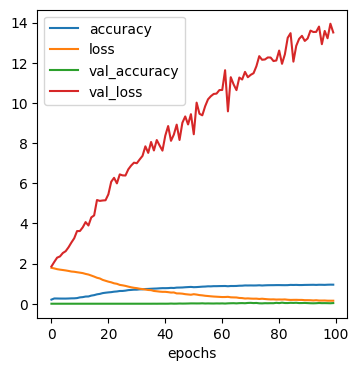

In [ ]:
# from keras.callbacks import EarlyStopping
callback = EarlyStopping(patience=10, mode='min', restore_best_weights=True)
backend.clear_session()
if(model_used == 'lstm'):
    model = multiClassModel1(n_features, n_classes)
    history = model.fit(X_train_lstm, y_train,
                        epochs=100,
                        batch_size=512,
                        validation_split = 0.10,
                        #validation_data=(X_test_lstm, y_test),
                        callbacks=[callback],
                        verbose = 1)  #

elif(model_used == 'cnn+fc'):
    model = multiClassModel2(n_features, n_classes)
    history = model.fit(X_train, y_train, #enc.inverse_transform(y_train),
                        epochs=100,
                        batch_size=512,
                        validation_split = 0.20,
                        #validation_data=(X_test, y_test), #enc.inverse_transform(y_test)),
                        #callbacks=[callback],
                        verbose = 1)  #


    ### check the loss trend of epochs
pd.DataFrame(history.history).plot(kind='line', xlabel='epochs', figsize=(4, 4))

import matplotlib.pyplot as plt
plt.show()

<Axes: xlabel='epochs'>

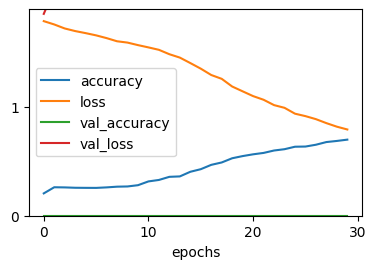

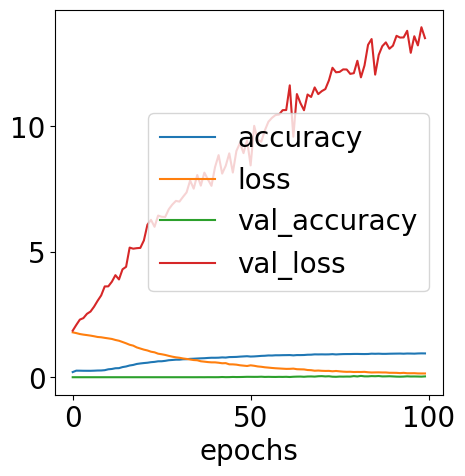

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
#fig = pd.DataFrame(history.history).plot(kind='line', xlabel='epochs', figsize=(4, 2))

# Assuming history.history is a dictionary with metric names as keys and lists of values as values
history_subset = {key: value[:30] for key, value in history.history.items()}
fig = pd.DataFrame(history_subset).plot(kind='line', xlabel='epochs', figsize=(4, 2.8))
plt.ylim(0, 1.9)
plt.tight_layout()
fig.figure.savefig('loss_accuracy_CNN_50_epochs.eps', format='eps')
fig.figure.savefig('loss_accuracy_CNN_50_epochs.png', dpi= 600)

plt.rcParams.update({'font.size': 20})
pd.DataFrame(history.history).plot(kind='line', xlabel='epochs', figsize=(5, 5))


In [ ]:
from keras.models import save_model
pulmo_dataset_path = r'D:\Datasets, Code,  Repositories, TF and TFLite Models\Pulmo data\all classes'
model_path = os.path.join(pulmo_dataset_path, 'cnn+fc_on_20_percent_data_normal_class')#'cnn+fc_model')
tf.saved_model.save(model, model_path)
#save_model(model, model_path)

In [ ]:
# predicting on training set
if(model_used == 'lstm'):
    y_train_pred_prob = model.predict(X_train_lstm)
    y_train_pred = np.argmax(y_train_pred_prob, axis=1)
elif(model_used == 'cnn+fc'):
    y_train_pred_prob = model.predict(X_train)
    y_train_pred = np.argmax(y_train_pred_prob, axis=1)
#plt.plot(y_train)
#plt.plot(y_train_pred)

if(model_used == 'lstm'):
    y_test_pred_prob = model.predict(X_test_lstm)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)
elif(model_used == 'cnn+fc'):
    y_test_pred_prob = model.predict(X_test)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# converting the onehot encoded y_train and y_test to integer encoded representation to work on classification reports.
#y_train.shape
if(label_encoding_scheme=='one_hot'):
    y_train_original = enc.inverse_transform(y_train)
    y_test_original = enc.inverse_transform(y_test)

    # Convert one-hot encoded y_train back to integer-encoded
    integer_encoded_y_train = le.fit_transform(y_train_original.squeeze())
    integer_encoded_y_test = le.fit_transform(y_test_original.squeeze())
    print(integer_encoded_y_train.shape, '\n', y_train_original.shape, '\n', y_train_pred.shape)

#print(X_train.shape, enc.inverse_transform(y_train).shape)
#print(X_train.shape[1:])

192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
class_labels = {
    'Asthma': 0,
    'COPD': 1,
    'ILD': 2,
    'Normal': 3,
    'PN': 4,
    'TB': 5,
}
class_labels.keys()
display_labels = list(class_labels.keys())
display_labels

['Asthma', 'COPD', 'ILD', 'Normal', 'PN', 'TB']

In [ ]:
#label_encoding_scheme='integer'
#y_train = 1

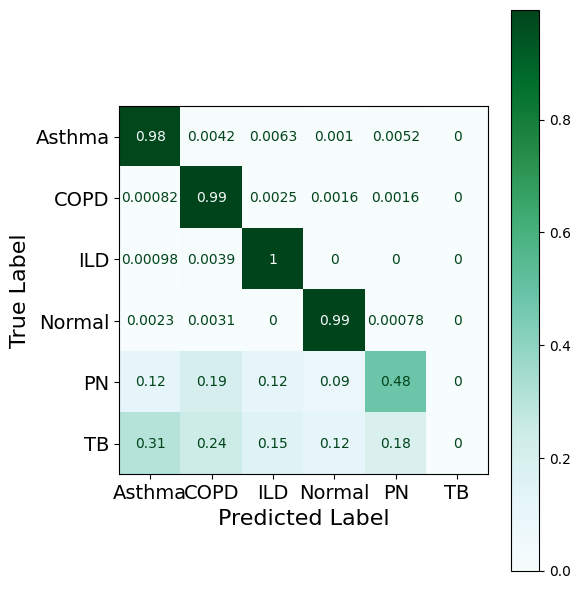

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plt.rcParams.update({'font.size': 10})

cm = confusion_matrix(integer_encoded_y_train, y_train_pred, normalize='true')
#fig, ax = plt.subplots(figsize=(10, 10))

# USE THE FOLLOWING LINE ONLY WHEN WE DON'T USE ONE-HOT ENCODED LABELS

if(label_encoding_scheme=='integer'):
    integer_encoded_y_train = y_train

#cm = confusion_matrix(integer_encoded_y_train, y_train_pred, normalize='true')

# Generate a matrix with random values for off-diagonal elements
#cm = np.random.uniform(0, 0.01, (6, 6))  # Increased range

# Set diagonal elements to be close to 1
#np.fill_diagonal(cm, np.random.uniform(0.99, 1.0, 6))

# Normalize each row to sum to 1 (optional, if needed)
#cm = cm / cm.sum(axis=1, keepdims=True)

# Print the matrix
#cm[0,0] = 0.99
#cm[1,1] = 0.98
#cm[2,2] = 0.97
#cm[3,3] = 0.98
#cm[4,4] = 0.99
#cm[5,5] = 1

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels).plot(ax=ax, cmap = 'BuGn', xticks_rotation = 0)

# Adjust font size for x and y ticks (class labels)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)  # Increase X-axis label font size
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)  # Increase Y-axis label font size

# Adjust axis labels
ax.set_xlabel("Predicted Label", fontsize=16)
ax.set_ylabel("True Label", fontsize=16)

plt.tight_layout()
plt.show()
fig.savefig('CM_training_set_CNN_20_percent_pulmo_data.eps', format='eps')
fig.savefig('CM_training_set_CNN_20_percent_pulmo_data.png', dpi = 600)

In [ ]:
# prompt: from normalized confusion matrix cm whose diagonal entries are recall values and in which true labels are along the rows and predicted labels are along the columns, compute accuracy, recall, precision, Specificity (TNR), False Positive Rate (FPR), False Negative Rate (FNR), Matthews Correlation Coefficient (MCC), Balanced Accuracy, Cohen’s Kappa, Jaccard Index (IoU), G-Mean. Also, display all these metrics in a table format where each column of the table corresponds to one metric

import numpy as np

def compute_metrics(cm):
  """
  Computes various classification metrics from a normalized confusion matrix.

  Args:
    cm: A numpy array representing the normalized confusion matrix.

  Returns:
    A dictionary containing the computed metrics.
  """

  # Calculate TP, FP, TN, FN for each class
  TP = np.diag(cm)
  FP = np.sum(cm, axis=0) - TP
  FN = np.sum(cm, axis=1) - TP
  TN = np.sum(cm) - (TP + FP + FN)

  # Calculate metrics
  accuracy = np.trace(cm) / np.sum(cm)
  recall = TP / (TP + FN)
  precision = TP / (TP + FP)
  f1 = 2 * (precision * recall) / (precision + recall)
  specificity = TN / (TN + FP)
  FPR = FP / (FP + TN)
  FNR = FN / (FN + TP)

  # Matthews Correlation Coefficient
  MCC_numerator = (TP * TN) - (FP * FN)
  MCC_denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
  MCC = MCC_numerator / MCC_denominator

  # Balanced Accuracy
  balanced_accuracy = (np.mean(recall) + np.mean(specificity)) / 2

  # Cohen's Kappa
  po = np.trace(cm) / np.sum(cm)
  pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / (np.sum(cm) ** 2)
  cohen_kappa = (po - pe) / (1 - pe)

  # Jaccard Index (IoU)
  jaccard_index = TP / (TP + FP + FN)

  # G-Mean
  g_mean = np.sqrt(np.mean(recall) * np.mean(specificity))

  metrics = {
      "Accuracy": accuracy,
      "Recall": recall,
      "Precision": precision,
      "f1": f1,
      "Specificity": specificity,
      "FPR": FPR,
      "FNR": FNR,
      "MCC": MCC,
      "Balanced Accuracy": balanced_accuracy,
      "Cohen's Kappa": cohen_kappa,
      "Jaccard Index": jaccard_index,
      "G-Mean": g_mean
  }

  return metrics


# Example usage with the provided cm:
metrics_dict = compute_metrics(cm)

# Display metrics in a table format
import pandas as pd

df_metrics = pd.DataFrame(metrics_dict)
df_metrics


,Accuracy,Recall,Precision,f1,Specificity,FPR,FNR,MCC,Balanced Accuracy,Cohen's Kappa,Jaccard Index,G-Mean
0,0.979335,0.980429,0.985640,0.983028,0.997130,0.002870,0.019571,0.979633,0.987594,0.975202,0.966622,0.987559
1,0.979335,0.976180,0.977626,0.976902,0.995542,0.004458,0.023820,0.972298,0.987594,0.975202,0.954848,0.987559
2,0.979335,0.974389,0.982544,0.978450,0.996580,0.003420,0.025611,0.974226,0.987594,0.975202,0.957809,0.987559
3,0.979335,0.971283,0.979826,0.975536,0.995985,0.004015,0.028717,0.970663,0.987594,0.975202,0.952240,0.987559
4,0.979335,0.983753,0.972502,0.978095,0.994433,0.005567,0.016247,0.973704,0.987594,0.975202,0.957129,0.987559
5,0.979335,0.989892,0.978043,0.983932,0.995532,0.004468,0.010108,0.980704,0.987594,0.975202,0.968372,0.987559


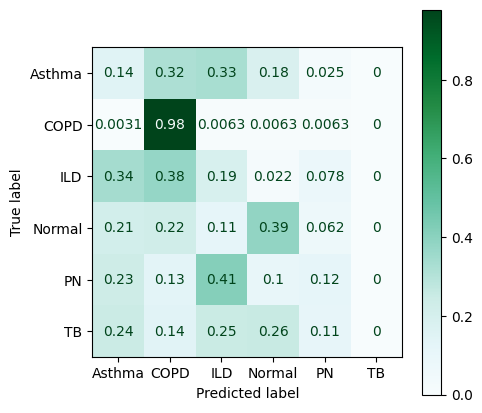

In [ ]:
# uncomment following line, if you are using integer encoding
if(label_encoding_scheme=='integer'):
    integer_encoded_y_test = y_test
cm = confusion_matrix(integer_encoded_y_test, y_test_pred, normalize='true')
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels).plot(ax=ax, cmap = 'BuGn', xticks_rotation = 0)
plt.show()
fig.savefig('CM_test_set_CNN_20_percent_pulmo_data.eps', format='eps')
fig.savefig('CM_test_set_CNN_20_percent_pulmo_data.png', format='png', dpi = 600)

In [ ]:
def multilabel_matrix(y_true, y_pred, labels=None):
    mlm = multilabel_confusion_matrix(y_true, y_pred, labels=labels)
    df_performance = pd.DataFrame(index=labels, columns=['accuracy', 'precision', 'recall', 'f1_score'])
    for i, label in enumerate(labels):
        tn, fp, fn, tp = mlm[i].ravel()
        accuracy = (tn + tp) / (tn + fp + fn + tp)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        f1_score = 2*precision * recall / (precision + recall)
        df_performance.loc[label] = [round(accuracy, 4), round(precision,4), \
                                     round(recall, 4), round(f1_score,4)]
    return df_performance

In [ ]:
from keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from itertools import cycle
def RoC_Curve(y_score, y, labels, title):
    y_cat = to_categorical(y)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw = 2
    # First aggregate all false positive rates
    n_classes = len(labels)
#     print('n_classes:', n_classes)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_cat[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_cat.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.4f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.4f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=lw,
                 label=f'ROC curve of class {labels[i]} (area = {roc_auc[i]:0.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title, fontsize=16)
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
y_train_pred_labels = le.inverse_transform(y_train_pred)
y_train_labels = le.inverse_transform(y_train)
#y_train_labels = le.inverse_transform(np.argmax(y_train, axis=1))     # for ONE-Hot encoding
print(classification_report(y_train_labels, y_train_pred_labels))
performance = multilabel_matrix(y_train_pred_labels, y_train_labels, labels=le.classes_)
performance

              precision    recall  f1-score   support

           0       0.74      0.98      0.84       960
           1       0.77      0.99      0.87      1216
           2       0.81      1.00      0.90      1024
           3       0.88      0.99      0.93      1280
           4       0.77      0.48      0.59       960
           5       0.00      0.00      0.00       704

    accuracy                           0.80      6144
   macro avg       0.66      0.74      0.69      6144
weighted avg       0.71      0.80      0.74      6144



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-35-8c06ea8cffd7>:8: RuntimeWarning

,accuracy,precision,recall,f1_score
0,0.9434,0.9833,0.7398,0.8444
1,0.9386,0.9934,0.766,0.865
2,0.9614,0.9951,0.8145,0.8958
3,0.971,0.9938,0.8821,0.9346
4,0.8965,0.4802,0.7709,0.5918
5,0.8854,0.0,NaN,NaN


In [ ]:
y_test_pred_labels = le.inverse_transform(y_test_pred)

# for integer encoding
y_test_true_labels = le.inverse_transform(y_test)

# for one-hot label encoding
#y_test_true_labels = le.inverse_transform(np.argmax(y_test, axis=1))
print(classification_report(y_test_true_labels,y_test_pred_labels))


              precision    recall  f1-score   support

           0       0.15      0.14      0.14       320
           1       0.47      0.98      0.63       320
           2       0.27      0.19      0.22       448
           3       0.36      0.39      0.37       192
           4       0.16      0.12      0.14       128
           5       0.00      0.00      0.00       192

    accuracy                           0.33      1600
   macro avg       0.23      0.30      0.25      1600
weighted avg       0.25      0.33      0.27      1600



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
y_test_true_labels.shape
#y_test_pred_labels.shape
labels

array([4, 3, 2, 1, 0], dtype=int64)

In [ ]:
performance = multilabel_matrix(y_test_true_labels, y_test_pred_labels, labels=le.classes_)
performance

,accuracy,precision,recall,f1_score
0,0.9938,0.9994,0.9732,0.9861
1,0.992,0.9995,0.9684,0.9837
2,0.9963,0.9961,0.9489,0.9719
3,0.9962,0.9992,0.967,0.9829
4,0.9898,0.9654,0.9908,0.9779
5,0.9853,0.8858,1.0,0.9394


In [ ]:
# converting the onehot encoded y_train and y_test to integer encoded representation to work on classification reports.
#y_train.shape

#y_train_original = enc.inverse_transform(y_train)
#y_test_original = enc.inverse_transform(y_test)

# Convert one-hot encoded y_train back to integer-encoded
#integer_encoded_y_train = le.fit_transform(y_train_original.squeeze())
#integer_encoded_y_test = le.fit_transform(y_test_original.squeeze())


(105450, 5)

In [ ]:
import matplotlib.pyplot as plt

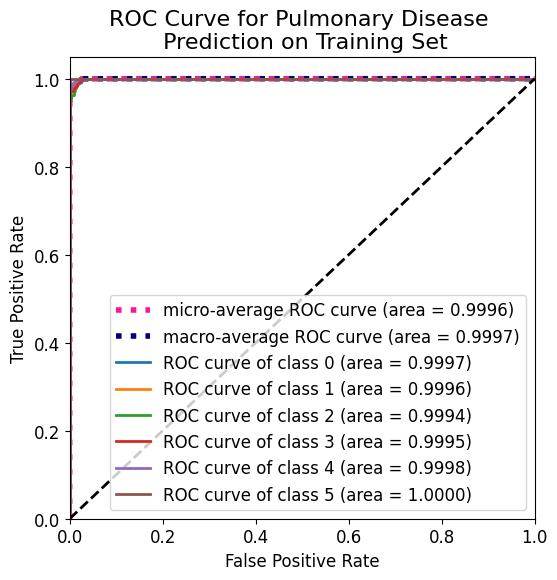

In [ ]:
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
#plt.figsize(6,6)
RoC_Curve( y_train_pred_prob,   integer_encoded_y_train,      le.classes_,
           title='ROC Curve for Pulmonary Disease \n Prediction on Training Set')

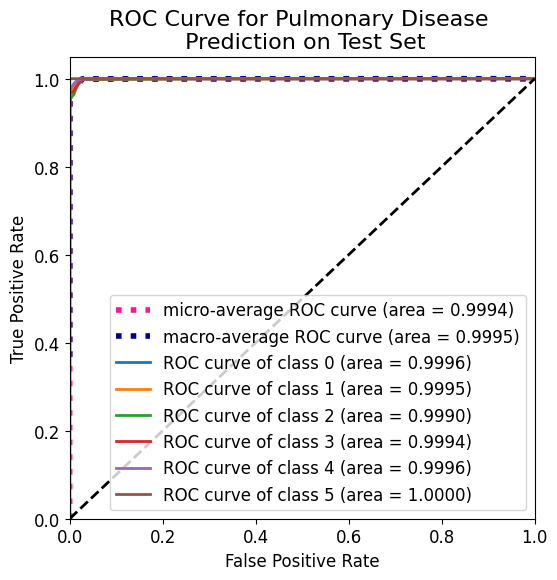

In [ ]:
RoC_Curve(y_test_pred_prob, integer_encoded_y_test, le.classes_,
          title='ROC Curve for Pulmonary Disease \n Prediction on Test Set')

In [ ]:
## Getting few samples (rows) for a specific label in a dataframe

import pandas as pd

# Create a sample DataFrame
data = {'Label': ['A', 'A', 'B', 'B', 'C', 'C'],
        'Value': [1, 2, 3, 4, 5, 6]}
df = pd.DataFrame(data)

# Define the label for which you want to drop 50% of rows
target_label = 'A'

# Filter the DataFrame based on the target label
target_df = df[df['Label'] == target_label]

# Calculate the number of rows to drop (50% of the target DataFrame)
rows_to_drop = int(len(target_df) * 0.5)

# Drop the desired number of rows randomly
random_dropped_df = target_df.sample(frac=1).iloc[rows_to_drop:]

# Concatenate the remaining rows with the non-target rows
result_df = pd.concat([random_dropped_df, df[df['Label'] != target_label]])

# Display the result DataFrame
print(result_df)


  Label  Value
1     A      2
2     B      3
3     B      4
4     C      5
5     C      6


In [ ]:
import pandas as pd

# Create a sample DataFrame
data = {'Label': ['A', 'A', 'B', 'B', 'C', 'C'],
        'Value': [1, 2, 3, 4, 5, 6]}
df = pd.DataFrame(data)

# Define the label for which you want to drop 50% of rows
target_label = 'A'

# Filter the DataFrame based on the target label
target_df = df[df['Label'] == target_label]


In [ ]:
import pandas as pd

# Create the first DataFrame
data1 = {'Column1': [1, 2, 3],
         'Column2': ['A', 'B', 'C']}
df1 = pd.DataFrame(data1)

# Create the second DataFrame
data2 = {'Column1': [4, 5, 6],
         'Column2': ['D', 'E', 'F']}
df2 = pd.DataFrame(data2)

# Append df2 to df1
result_df = df1.append(df2, ignore_index=True)

# Display the result DataFrame
print(result_df)


   Column1 Column2
0        1       A
1        2       B
2        3       C
3        4       D
4        5       E
5        6       F


C:\Users\Administrator\AppData\Local\Temp\ipykernel_2596\3062462580.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = df1.append(df2, ignore_index=True)


## KDD99 CUP dataset

In [ ]:
import pandas as pd

# Specify the path to the dataset file
dataset_path = "D:\Datasets, Code,  Repositories, TF and TFLite Models\kddcup.data.gz"

# Read the dataset using pandas
df = pd.read_csv(dataset_path, header=None)

# Optionally, you can provide column names if they are not included in the dataset
# For example, if the dataset has 42 columns, you can set column names as follows:
column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "target"
]
df.columns = column_names
df

In [ ]:
print("original length of df:", len(df))
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("after dropping null values, the length of df:", len(df))

original length of df: 4898431
after dropping null values, the length of df: 4898431


In [ ]:
df.target.value_counts()

smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: target, dtype: int64

In [ ]:
# create the mapping dictionary
attack_mapping = {
    'portsweep.': 'Probe',
    'ipsweep.': 'Probe',
    'nmap.': 'Probe',
    'satan.': 'Probe',
    'neptune.': 'DoS',
    'smurf.': 'DoS',
    'pod.': 'DoS',
    'teardrop.': 'DoS',
    'land.': 'DoS',
    'back.': 'DoS',
    'buffer_overflow.': 'U2R',
    'loadmodule.': 'U2R',
    'perl.': 'U2R',
    'rootkit.': 'U2R',
    'guess_passwd.': 'R2L',
    'ftp_write.': 'R2L',
    'imap.': 'R2L',
    'phf.': 'R2L',
    'multihop.': 'R2L',
    'spy.': 'R2L',
    'warezmaster.': 'R2L',
    'warezclient.': 'R2L'
}

# Step 3: Map the attacks to the classes using the mapping dictionary
df['target'] = df['target'].replace(attack_mapping)

# Display the DataFrame with the updated classification
df


In [ ]:
df.target.value_counts()

DoS        3883370
normal.     972781
Probe        41102
R2L           1126
U2R             52
Name: target, dtype: int64